*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

You should create a function called `predict_message` that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the [SMS Spam Collection dataset](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.


In [ ]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
  !pip install numpy --upgrade
  !pip install tensorflow-datasets
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

In [ ]:
# create training and testing datasets
CSV_COLUMN_NAMES = ["filter","text"]
FILTERS = ['spam', 'ham']

train_data = pd.read_csv(train_file_path,sep='\t', header=None,names=CSV_COLUMN_NAMES)
test_data = pd.read_csv(test_file_path,sep='\t', header=None,names=CSV_COLUMN_NAMES)

# getting the labels
train_label = train_data.pop('filter').astype('category').cat.codes
test_label = test_data.pop('filter').astype('category').cat.codes



In [ ]:
# processing text values
import nltk
nltk.download('stopwords') # download stopwords
nltk.download('wordnet')   # download vocab for lemmatizer
import re
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
stopwords_eng = set(stopwords.words('english'))
len(stopwords_eng)

lemmatizer = WordNetLemmatizer()

def clean_txt(txt):
    txt = re.sub(r'([^\s\w])+', ' ', txt)
    txt = " ".join([lemmatizer.lemmatize(word) for word in txt.split()
                    if not word in stopwords_eng])
    txt = txt.lower()
    return txt

train_data = train_data['text'].apply(lambda x: clean_txt(x))


# for vectorization
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

# Keep top 1000 frequently occurring words
max_words = 1000

# Cut off the words after seeing 500 words in each document
max_len = 500

t = Tokenizer(num_words=max_words)
t.fit_on_texts(train_data)

# Transform each text to a sequence of integers
sequences = t.texts_to_sequences(train_data)
sequences[:5]

# Make all rows of equal length
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)
sequences_matrix[:5]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


array([[  0,   0,   0, ...,  54, 228,  86],
       [  0,   0,   0, ...,   0, 195, 252],
       [  0,   0,   0, ...,   6, 338, 422],
       [  0,   0,   0, ...,   8, 243,  43],
       [  0,   0,   0, ..., 124,  70,  24]], dtype=int32)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_19 (Embedding)    (None, 500, 50)           50000     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense_11 (Dense)            (None, 256)               16640     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 1)                 257       
                                                                 
Total params: 96,337
Trainable params: 96,337
Non-trainable

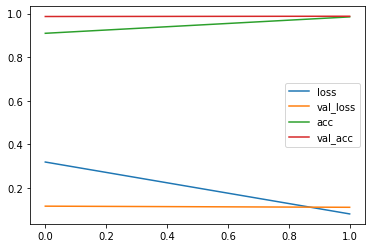

In [ ]:
# creating embedding layer
inp = tf.keras.layers.Input(shape=[max_len])
out = tf.keras.layers.Embedding(max_words, 50, input_length=max_len)(inp)
out = tf.keras.layers.LSTM(64)(out)

out = tf.keras.layers.Dense(256, activation='relu')(out)
out = tf.keras.layers.Dropout(0.5)(out)
out = tf.keras.layers.Dense(1, activation='relu')(out)

model = tf.keras.models.Model(inputs=inp, outputs=out)
model.compile(
    loss='binary_crossentropy',
    optimizer='RMSprop',
    metrics=['accuracy']
)
model.summary()

history = model.fit(sequences_matrix, train_label,
              batch_size=32, epochs=10,
              validation_split=0.2,
              callbacks=[tf.keras.callbacks.EarlyStopping(
                  monitor='val_loss', min_delta=0.0001)])

# to plot the model
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

In [ ]:
# to pre process text and testing
def preprocessing(X):
  x = X.apply(lambda x: clean_txt(x))
  x = t.texts_to_sequences(x)
  return sequence.pad_sequences(x, maxlen=max_len)

s = model.evaluate(preprocessing(test_data['text']), test_label)

print('Loss: {:.3f}, Accuracy: {:.3f}'.format(s[0], s[1]))

44/44 [==============================] - 3s 56ms/step - loss: 0.0780 - accuracy: 0.9871
Loss: 0.078, Accuracy: 0.987


In [ ]:


# function to predict messages based on model

def predict_message(pred_text):
  p = model.predict(preprocessing(pd.Series([pred_text])))[0]

  return (p[0], ("ham" if p<0.5 else "spam"))

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 0s 422ms/step
(0.0, 'ham')


In [ ]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 35ms/step
You passed the challenge. Great job!
